In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import widgets
import seaborn as sns
from scipy.signal import find_peaks
from time import time
import feather
import xlsxwriter 

# Limpieza de datos

In [2]:
def dtfr():
    df = pd.read_excel("Consumo horario Zonas de carga de la GCROC 2015-2019.xlsx", sheet_name="datos")
    return df

In [3]:
# dtfr().head()

##### Remoción de primer encabezado y cambio de nombres en segundo encabezado

In [4]:
def lim_header():
    dfi = dtfr()
    dfi.columns = dfi.iloc[0]
    dfi = dfi.drop(index=0)
    dfi.rename(columns = {"día de la semana" : "día_semana"}, inplace=True )
    dfi.rename(columns = {pd.NaT : "fechas"}, inplace = True)
    return dfi

##### Relleno día semana y fecha 

In [5]:
def lim_relleno():
    df = lim_header()
    dia_sem = df["día_semana"].tolist()
    fech = df["fecha"].tolist()
    hor = df["hora"].tolist()
    indx = 0
    for h in hor:
        if h == 1:
            fecha = fech[indx]
            diaa = dia_sem[indx]
            indx += 1
        elif h != 1:
            fech[indx] = fecha
            dia_sem[indx] = diaa
            indx += 1
    df["fecha"] = fech
    df["día_semana"] = dia_sem
    return df

#### Remplazo de valores no numéricos

In [6]:
def lim_Nnum():
    df = lim_relleno()
    df['year'] = pd.DatetimeIndex(df["fechas"]).year
    df['month'] = pd.DatetimeIndex(df["fechas"]).month
    df['day'] = pd.DatetimeIndex(df["fechas"]).day

    df = df.replace(["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"], [0, 1, 2, 3, 4, 5, 6])
    df = df.replace(["Miércoles", "Sábado"],[2,5])

    df = df.drop(["fecha","fechas"], axis=1)
    df = df.dropna()
    
    return df

#### Cambio de nombre a zonas de carga

In [7]:
def lim_nomzon():
    df = lim_Nnum()
    zonas = df.columns
    elim = ["día_semana", "hora", "day", "year", "month"]
    zonas = zonas.drop(elim)
    son = ["zona_{}".format(i+1) for i in range(len(zonas))]
    listDic={}
    for zona, so in zip(zonas, son):
        listDic[zona]=so
    df.rename(columns = listDic, inplace=True )
    return df

###### llama los datos más rapido

In [8]:
# path = 'my_data.feather'
# feather.write_dataframe(lim_nomzon(), path)
# df = feather.read_dataframe(path)

# Creación de variables "Dummies"

#### Adición de días festivos con penalización

In [9]:
def dum_fest(df):
    cata = []; fes = pd.read_csv("festivos.csv")
    for j in range(len(fes.index)):
            festiveDay = df.loc[(df.year==fes["Year"][j]) & (df.month==fes["Month"][j]) & (df.day==fes["Day"][j])].index.values.tolist()
            cata = cata + festiveDay

    df['fest'] = np.nan; df.fest = df.fest.fillna(pd.Series(-1, index=cata))
    df.fest = df.fest.fillna(0)
    df = df.query("fest == 0")
    df = df.drop("fest", axis = 1)
    return df

#### Variables "Dummies" día de la semana

In [10]:
# lunes   martes-miercoles-jueves   viernes   sabado   domingo
def dum_dia(df):
    df.día_semana=df.día_semana.apply(lambda x: 1 if x==1 else (2 if x in [2,3,4] else (3 if x==5 else (4 if x==6 else 0))))
    df = pd.get_dummies(df, prefix=['d_sm'], columns=['día_semana'])
    df = df.drop("d_sm_0", axis = 1)
    return df

In [11]:
# # lunes  martes  miercoles  jueves  viernes  sabado  domingo
# def dum_dia(df):
#     df.día_semana=df.día_semana.apply(lambda x: 1 if x==1 else (2 if x==2 else (3 if x==3 else (4 if x==4 else (5 if x==5 else (6 if x==6 else 0))))))
#     df = pd.get_dummies(df, prefix=['d_sm'], columns=['día_semana'])
#     df = df.drop("d_sm_0", axis = 1)
#     return df

##### "Dummies" mensuales

In [12]:
def dum_mensual(df):
    # Enero, Febrero, Marzo, Abril, Mayo, Junio, Julio, Agosto, Septiembre, Octubre, Diciembre
    df = pd.get_dummies(df, prefix=['mm'], columns=['month'])
    df = df.drop("mm_12", axis = 1)
    return df

#### "Dummies" de temporada

In [13]:
def dum_seas(df):
    df['seas'] = np.nan
    pr = df.query('day == 21 and month ==3').index
    vr = df.query('day == 21 and month == 6').index
    ot = df.query('day == 21 and month == 9').index
    inv= df.query('day == 21 and month == 12').index

    df.seas = df.seas.fillna(pd.Series(0, index=pr))
    df.seas = df.seas.fillna(pd.Series(1, index=vr))
    df.seas = df.seas.fillna(pd.Series(2, index=ot))
    df.seas = df.seas.fillna(pd.Series(3, index=inv))

    df.seas = df.seas.fillna(method= 'ffill')
    df.seas = df.seas.fillna(method= 'bfill')

    df = pd.get_dummies(df, prefix=['s_s'], columns=['seas'])
    df = df.drop("s_s_3.0", axis = 1)

    return df

----------------------------------------------------------------------

#### llamada funciones dummies

In [14]:
def dumm():
    df = feather.read_dataframe('my_data.feather')
    df = dum_fest(df)
#     df = dum_dia(df)
#     df = dum_seas(df)
    df = dum_mensual(df)
    return df

In [15]:
beg = time()
df = dumm()
df.head()
end = time()
end - beg

1.2616088390350342

In [17]:
# hora_ = 6; zona_ = 'zona_6'; armon_ = 0

# workbook = xlsxwriter.Workbook('mapes_15_1.xlsx')
# worksheet = workbook.add_worksheet()
# j = (row for row in range(2, 700))
# beg = time()
# y = pd.Series(get_zon_hor(hora_ , zona_))
# for armon_ in range(0, 9):
#     x, x2, y_pred, y_pred2, y_pred3, ms = reg(hora_, zona_, armon_)

# end = time()
# print('\n tiempo de corrida:', end - beg)
# workbook.close()

In [18]:
df.columns

Index(['día_semana', 'hora', 'zona_1', 'zona_2', 'zona_3', 'zona_4', 'zona_5',
       'zona_6', 'zona_7', 'zona_8', 'zona_9', 'zona_10', 'zona_11', 'zona_12',
       'zona_13', 'zona_14', 'zona_15', 'zona_16', 'zona_17', 'zona_18',
       'zona_19', 'zona_20', 'zona_21', 'zona_22', 'zona_23', 'zona_24',
       'zona_25', 'zona_26', 'year', 'day', 'mm_1', 'mm_2', 'mm_3', 'mm_4',
       'mm_5', 'mm_6', 'mm_7', 'mm_8', 'mm_9', 'mm_10', 'mm_11'],
      dtype='object')

#### Función para lista con nombre de zonas

In [19]:
def sonas():
    zonas = df.columns; son = ["zona_{}".format(i+1) for i in range(26)]
    return son
son = sonas()

----------------------------------------------------------------------

# Funciones para regresíon

- Función para obtencion de serie con datos $hora:i$ y $zona:j$

In [20]:
def get_zon_hor(h,z):
    hora_n = df.query('hora == {}'.format(h))
    zon_n = hora_n['{}'.format(z)]
    return zon_n.values

- Función para obtención de Dummies

In [21]:
def get_dums(h):
    dem = ['hora', 'year', 'month']
    zro = son #+ dem
    sin_zonas = df.query(f'hora == {h}')
    sin_zonas=sin_zonas.reset_index()
    sin_zonas = sin_zonas.drop(zro,  axis=1)
    sin_zonas = sin_zonas.drop(['index', 'hora'], axis=1)
    sin_zonas["ones"] = 1
    return  sin_zonas

- Función de Kronecker solo con dummies

In [22]:
def kron1(h, z):
    #Definicion de valores
    dm1 = get_dums(h); y = get_zon_hor(h, z)
    kron = pd.DataFrame()
    t = pd.DataFrame(np.arange(0, len(y)).tolist()); t.columns = ["te"]
    error = pd.DataFrame()
    
    #Primer kronecker
    kron = dm1.multiply(t["te"] , axis="index")
    kron.columns = [f'{i}_t' for i in dm1.columns]
    kron1 = pd.concat([kron, get_dums(h)], sort = False, axis=1)
    kron1 = kron1.drop("year_t", axis = 1)
    
    return kron1

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

- Función de MAPE general

In [24]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ma = np.mean(np.abs((y_true - y_pred) / y_true) * 100)
    return ma

- Función de MAPE hora por hora

In [25]:
def MAPE_hor(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ma = np.abs((y_true - y_pred) / y_true) * 100
    return ma

In [26]:
def plot_mpdummies(h, z):
    y = get_zon_hor(h, z)
    kron = kron1(h, z)
    
    #Regresion
    reg = LinearRegression(n_jobs = -1, fit_intercept=False).fit(kron, y)
    y_pred = reg.predict(kron)
    
    #mapes
    map3 = MAPE_hor(y, y_pred)
    
    #grafico 1
    plt.figure(figsize=(13,13))
    plt.plot(y, label='real')
    plt.plot(y_pred, label='prediccíon')
    plt.plot(map3, label="MAPE")
    plt.xlabel("Día")
    plt.ylabel("Consumo Mwh")
    plt.title("Ajuste de modelo vs consumo real")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    #grafico 2
    plt.figure(figsize=(14,12))
    plt.plot(map3, label="MAPE")
    plt.grid(True)
    plt.xlabel("día")
    plt.ylabel("Mape")
    plt.legend(loc="best")
    plt.title("MAPE de model de dummies")
    plt.show()
    return

In [27]:
# plot_mpdummies(5, "zona_5")

- Función de regresion_1 para obtener error y calcular picos

In [28]:
from  scipy.signal import periodogram

In [29]:
def kron_dif(h, z):
    y = get_zon_hor(h, z)
    kron = kron1(h, z)
    #Regresion
    reg = LinearRegression(n_jobs = -1, fit_intercept=False).fit(kron, y)
    y_pred = reg.predict(kron)
    
    #mapes
    map3 = MAPE_hor(y, y_pred)

    
    #Para encontrar picos
    mp50, _ = find_peaks(map3, height=50)
    mp40, _ = find_peaks(map3, height=40)
    mp30, _ = find_peaks(map3, height=30)
    mp20, _ = find_peaks(map3, height=20)
    mp10, _ = find_peaks(map3, height=10)
    
    # Restar picos de otras alturas
    mp10 = np.setdiff1d(mp10, mp20)
    mp20 = np.setdiff1d(mp20, mp30)
    mp30 = np.setdiff1d(mp30, mp40)
    mp40 = np.setdiff1d(mp40, mp50)
    
    
    kron["dif"] = np.nan
    kron.dif = kron.dif.fillna(pd.Series(-1, index=mp10))
    kron.dif = kron.dif.fillna(pd.Series(-2, index=mp20))
    kron.dif = kron.dif.fillna(pd.Series(-3, index=mp30))
    kron.dif = kron.dif.fillna(pd.Series(-4, index=mp40))
    kron.dif = kron.dif.fillna(pd.Series(-5, index=mp50))
    kron.dif = kron.dif.replace(np.nan, 0)    
    
    return kron

In [30]:
def pks_error(h, z, armon):
    import warnings
    warnings.filterwarnings("ignore")
    
    y = get_zon_hor(h, z)
    kron = kron_dif(h, z)
    #Regresion
    reg = LinearRegression(n_jobs = -1, fit_intercept=False).fit(kron, y)
    y_pred = reg.predict(kron)
    
    #Error
    error = (y-y_pred)
    f, asd = periodogram(error, fs=1)
    peaks, _ = find_peaks(asd, height = 0)
    altura = _['peak_heights']
    fan = np.round(1/(f[peaks]))
#     plt.figure(figsize=(20, 10))
#     plt.plot(1/f, asd)
#     plt.scatter(1/fan, altura, marker = "x", c = "g")
    app = pd.DataFrame(altura, fan, columns=["altura_pk"]).sort_values(by="altura_pk",ascending=False).head(armon).iloc[armon-1:]
    return app

In [37]:
pks_error(1, "zona_1", 6)

,altura_pk
36.0,26473.918191


### - Función para obtención de coeficientes de senos y cosenos

In [53]:
def get_sc_coef(h, z, armon):
    X = pd.DataFrame()
    t = np.arange(len(df[df["hora"]==h]))
    p = pks_error(h, z, armon)
    for i  in p.index:
        X["{:.1f}_sen".format(i)] = np.sin((t*2*np.pi)/i)
        X["{:.1f}_cos".format(i)] = np.cos((t*2*np.pi)/i)
    return X

In [54]:
get_sc_coef(1, "zona_1", 0);

- Funcion de multiplicación de filas por Kronecker + addición de variables Dummies y coeficientes

In [181]:
def kron_conv(h, z, armon):
    #Definicion de valores
    y = get_zon_hor(h, z)
    t = pd.DataFrame(np.arange(1, len(y)+1).tolist()); t.columns = ["te"]

    
    #Segundo kronecker
    dm1 = kron_dif(h, z); dm2 = get_sc_coef(h, z, armon)
#     dm1 = dm1.drop("dif", axis = 1)
    d3 = pd.DataFrame(); kron = pd.DataFrame()
    for i in dm2.columns:
        d3 = dm1.multiply(dm2[f"{i}"], axis="index")
        d3.columns = [f"{j}_{i}" for j in dm1.columns]
        kron = pd.concat([kron, d3], axis = 1)
    
    X = kron.reset_index()
    X2 = pd.concat([X, get_dums(h), get_sc_coef(h, z, armon)], sort = False, axis=1)
    X2 = X2.drop('index', axis = 1)
    return X2

## Regresión 

In [56]:
def get_train_split_sick(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.004, shuffle = False) #0.015
    return X_train, X_test, y_train, y_test

In [57]:
def get_train_split_xgb(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size =  float(format(5/len(y_test), '.3f')), shuffle = False) #0.06
    return X_train, X_test, X_val, y_train, y_test, y_val 

In [58]:
from statsmodels.tsa.ar_model import AR
# from statsmodels.tsa.arima_model import ARMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor 

In [59]:
def reg(h, z, armon):
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
   
    y = pd.Series(get_zon_hor(h, z))
    X = kron_conv(h, z, armon)
    X_tr, X_te, y_tr, y_te = get_train_split_sick(X, y)
    i = next(j)
    
    #Regresión con scikitlearn
    regress = LinearRegression(fit_intercept=True, n_jobs=-1, normalize=True).fit(X_tr, y_tr)
    y_pred = regress.predict(X_te)
    m1 = MAPE(y_te, y_pred)

    #Regressión con XGBoost
    X_train, X_test, X_val, y_train, y_test, y_val = get_train_split_xgb(X, y)
    regress2 = XGBRegressor(objective ='reg:squarederror', n_jobs=-1, max_depth=3, learning_rate=1.5, n_estimators=5)#
    regress2.fit(X_train, y_train, eval_set=[(X,y),(X_val,y_val)], verbose=0)#, , early_stopping_rounds=50)
    y_pred2 = regress2.predict(X_test)
    m2 = MAPE(y_test, y_pred2)
    
    #Autoregresión
    regresar = AR(y_tr).fit()
    y_predico = regresar.predict(start=len(y_tr), end=len(y_tr) + len(y_te)-1, dynamic=False)
    m3 = MAPE(y_te, y_predico)
    
    
    worksheet.write(f'A{i}', m1)
    worksheet.write(f'B{i}', m2)
    worksheet.write(f'C{i}', m3)
    worksheet.write(f'D{i}', z)
    worksheet.write(f'E{i}', h)
    i +=1
    
    # Valores de Y que concuerdan con indice de y_pred y y_pred2
    ma = [m1 + m2 + m3]
    print("{}, hora_{}: Scikit_{:.3f} XGBoost_{:.3f} AR_{:.3f} \n".format(z, h, m1, m2, m3))
    return y_te.index, y_test.index, y_pred, y_pred2, y_predico, ma;

Corrida funcíon de regresión

In [62]:
hora_ = 7; zona_ = 'zona_6'; armon_ = 0

In [63]:
workbook = xlsxwriter.Workbook('mapes_15_1.xlsx')
worksheet = workbook.add_worksheet()
j = (row for row in range(2, 700))
beg = time()
y = pd.Series(get_zon_hor(hora_ , zona_))
x, x2, y_pred, y_pred2, y_pred3, ms = reg(hora_, zona_, armon_)

end = time()
print('\n tiempo de corrida:', end - beg)
workbook.close()

zona_6, hora_7: Scikit_2.038 XGBoost_6.684 AR_17.075 


 tiempo de corrida: 0.35758161544799805


Corrida para todas las zonas en todos los horarios

In [196]:
beg = time()
workbook = xlsxwriter.Workbook('mapes_ds.xlsx')
for armonico_ in range(0, 9):
    worksheet = workbook.add_worksheet(f"zh_1_{armonico_}")
    worksheet.write('A1', f'Sck_{armonico_}') 
    worksheet.write('B1', f'XGB_{armonico_}')
    worksheet.write('C1', f'AR_{armonico_}')
    worksheet.write('D1', f'Zona_{armonico_}')
    worksheet.write('E1', f'hora_{armonico_}')
    j = (row for row in range(2, 700))
    for zona_ in son:
        for hora_ in range(1, 25):                
            reg(hora_, zona_, armonico_)
print('\n tiempo de corrida:', end - beg)
workbook.close()
end = time()
end - beg

zona_1, hora_1: Scikit_4.971 XGBoost_8.109 AR_7.927 

zona_1, hora_2: Scikit_6.515 XGBoost_6.780 AR_5.234 

zona_1, hora_3: Scikit_8.257 XGBoost_6.712 AR_6.706 

zona_1, hora_4: Scikit_7.068 XGBoost_5.877 AR_5.869 

zona_1, hora_5: Scikit_7.829 XGBoost_8.884 AR_6.600 

zona_1, hora_6: Scikit_8.317 XGBoost_8.584 AR_6.503 

zona_1, hora_7: Scikit_8.107 XGBoost_8.027 AR_7.439 

zona_1, hora_8: Scikit_9.363 XGBoost_9.609 AR_9.585 

zona_1, hora_9: Scikit_9.424 XGBoost_6.651 AR_8.471 

zona_1, hora_10: Scikit_8.712 XGBoost_9.762 AR_8.688 

zona_1, hora_11: Scikit_11.544 XGBoost_6.565 AR_10.268 

zona_1, hora_12: Scikit_10.182 XGBoost_6.667 AR_9.118 

zona_1, hora_13: Scikit_8.788 XGBoost_3.934 AR_6.563 

zona_1, hora_14: Scikit_10.304 XGBoost_6.433 AR_7.900 

zona_1, hora_15: Scikit_10.215 XGBoost_6.443 AR_8.115 

zona_1, hora_16: Scikit_10.919 XGBoost_7.891 AR_9.451 

zona_1, hora_17: Scikit_9.733 XGBoost_5.475 AR_7.079 

zona_1, hora_18: Scikit_4.261 XGBoost_16.500 AR_5.391 

zona_1, hora

zona_7, hora_4: Scikit_4.550 XGBoost_7.886 AR_6.551 

zona_7, hora_5: Scikit_7.373 XGBoost_10.602 AR_9.076 

zona_7, hora_6: Scikit_8.837 XGBoost_6.670 AR_9.851 

zona_7, hora_7: Scikit_4.847 XGBoost_9.181 AR_5.513 

zona_7, hora_8: Scikit_4.338 XGBoost_4.125 AR_7.003 

zona_7, hora_9: Scikit_5.132 XGBoost_11.692 AR_6.262 

zona_7, hora_10: Scikit_3.418 XGBoost_11.062 AR_5.840 

zona_7, hora_11: Scikit_3.508 XGBoost_7.913 AR_5.597 

zona_7, hora_12: Scikit_3.978 XGBoost_10.406 AR_4.671 

zona_7, hora_13: Scikit_3.936 XGBoost_22.360 AR_4.658 

zona_7, hora_14: Scikit_3.722 XGBoost_10.953 AR_5.496 

zona_7, hora_15: Scikit_4.021 XGBoost_8.637 AR_4.412 

zona_7, hora_16: Scikit_3.312 XGBoost_11.419 AR_6.403 

zona_7, hora_17: Scikit_3.617 XGBoost_13.182 AR_6.972 

zona_7, hora_18: Scikit_4.026 XGBoost_6.599 AR_6.792 

zona_7, hora_19: Scikit_3.958 XGBoost_8.836 AR_5.838 

zona_7, hora_20: Scikit_5.241 XGBoost_9.425 AR_3.302 

zona_7, hora_21: Scikit_3.005 XGBoost_3.466 AR_3.101 

zona_7, 

zona_13, hora_6: Scikit_12.844 XGBoost_11.504 AR_10.605 

zona_13, hora_7: Scikit_13.478 XGBoost_31.812 AR_11.872 

zona_13, hora_8: Scikit_14.900 XGBoost_14.337 AR_12.890 

zona_13, hora_9: Scikit_13.874 XGBoost_21.494 AR_12.847 

zona_13, hora_10: Scikit_13.642 XGBoost_11.936 AR_12.894 

zona_13, hora_11: Scikit_13.287 XGBoost_10.956 AR_10.809 

zona_13, hora_12: Scikit_12.234 XGBoost_22.868 AR_8.539 

zona_13, hora_13: Scikit_11.583 XGBoost_18.452 AR_8.604 

zona_13, hora_14: Scikit_12.951 XGBoost_19.511 AR_10.907 

zona_13, hora_15: Scikit_12.952 XGBoost_19.563 AR_9.266 

zona_13, hora_16: Scikit_12.545 XGBoost_8.751 AR_8.059 

zona_13, hora_17: Scikit_11.863 XGBoost_29.258 AR_6.173 

zona_13, hora_18: Scikit_12.792 XGBoost_10.739 AR_7.889 

zona_13, hora_19: Scikit_12.819 XGBoost_29.330 AR_8.088 

zona_13, hora_20: Scikit_11.305 XGBoost_22.163 AR_6.757 

zona_13, hora_21: Scikit_11.537 XGBoost_28.044 AR_7.418 

zona_13, hora_22: Scikit_12.571 XGBoost_23.457 AR_9.201 

zona_13, hor

zona_19, hora_8: Scikit_5.683 XGBoost_11.152 AR_4.252 

zona_19, hora_9: Scikit_6.067 XGBoost_11.641 AR_4.438 

zona_19, hora_10: Scikit_7.097 XGBoost_16.439 AR_5.192 

zona_19, hora_11: Scikit_8.878 XGBoost_15.319 AR_6.631 

zona_19, hora_12: Scikit_9.601 XGBoost_18.056 AR_7.081 

zona_19, hora_13: Scikit_9.804 XGBoost_15.519 AR_7.548 

zona_19, hora_14: Scikit_9.462 XGBoost_18.985 AR_6.987 

zona_19, hora_15: Scikit_7.787 XGBoost_17.188 AR_5.413 

zona_19, hora_16: Scikit_6.844 XGBoost_16.697 AR_5.864 

zona_19, hora_17: Scikit_6.367 XGBoost_2.381 AR_6.104 

zona_19, hora_18: Scikit_5.360 XGBoost_15.850 AR_5.897 

zona_19, hora_19: Scikit_4.709 XGBoost_5.695 AR_5.804 

zona_19, hora_20: Scikit_4.223 XGBoost_4.998 AR_6.108 

zona_19, hora_21: Scikit_2.825 XGBoost_3.324 AR_5.537 

zona_19, hora_22: Scikit_2.341 XGBoost_9.470 AR_4.808 

zona_19, hora_23: Scikit_1.960 XGBoost_5.466 AR_5.502 

zona_19, hora_24: Scikit_2.506 XGBoost_4.966 AR_4.916 

zona_20, hora_1: Scikit_2.493 XGBoost_2.

zona_25, hora_10: Scikit_5.075 XGBoost_11.698 AR_3.165 

zona_25, hora_11: Scikit_5.873 XGBoost_10.886 AR_2.435 

zona_25, hora_12: Scikit_5.736 XGBoost_5.446 AR_2.578 

zona_25, hora_13: Scikit_6.867 XGBoost_8.248 AR_3.232 

zona_25, hora_14: Scikit_6.760 XGBoost_4.036 AR_2.952 

zona_25, hora_15: Scikit_7.331 XGBoost_4.024 AR_2.694 

zona_25, hora_16: Scikit_7.931 XGBoost_5.255 AR_3.908 

zona_25, hora_17: Scikit_7.149 XGBoost_4.811 AR_3.095 

zona_25, hora_18: Scikit_6.602 XGBoost_4.250 AR_3.476 

zona_25, hora_19: Scikit_5.616 XGBoost_6.515 AR_3.760 

zona_25, hora_20: Scikit_5.345 XGBoost_14.461 AR_3.928 

zona_25, hora_21: Scikit_5.067 XGBoost_6.813 AR_4.443 

zona_25, hora_22: Scikit_5.915 XGBoost_4.496 AR_4.707 

zona_25, hora_23: Scikit_7.105 XGBoost_7.842 AR_4.629 

zona_25, hora_24: Scikit_6.508 XGBoost_7.716 AR_3.178 

zona_26, hora_1: Scikit_5.432 XGBoost_15.090 AR_5.717 

zona_26, hora_2: Scikit_3.914 XGBoost_7.539 AR_3.457 

zona_26, hora_3: Scikit_5.031 XGBoost_5.047 AR

zona_5, hora_13: Scikit_4.812 XGBoost_13.010 AR_5.982 

zona_5, hora_14: Scikit_6.070 XGBoost_12.650 AR_6.148 

zona_5, hora_15: Scikit_4.486 XGBoost_12.675 AR_5.835 

zona_5, hora_16: Scikit_5.315 XGBoost_2.487 AR_5.602 

zona_5, hora_17: Scikit_4.926 XGBoost_9.883 AR_5.865 

zona_5, hora_18: Scikit_4.834 XGBoost_5.151 AR_6.352 

zona_5, hora_19: Scikit_2.783 XGBoost_6.533 AR_5.906 

zona_5, hora_20: Scikit_6.244 XGBoost_15.879 AR_10.139 

zona_5, hora_21: Scikit_6.791 XGBoost_11.404 AR_10.919 

zona_5, hora_22: Scikit_5.905 XGBoost_11.114 AR_10.432 

zona_5, hora_23: Scikit_5.763 XGBoost_12.044 AR_10.661 

zona_5, hora_24: Scikit_7.431 XGBoost_9.352 AR_9.466 

zona_6, hora_1: Scikit_53.193 XGBoost_37.558 AR_28.580 

zona_6, hora_2: Scikit_52.625 XGBoost_38.012 AR_28.345 

zona_6, hora_3: Scikit_56.697 XGBoost_43.284 AR_21.144 

zona_6, hora_4: Scikit_57.459 XGBoost_44.314 AR_21.543 

zona_6, hora_5: Scikit_58.065 XGBoost_42.511 AR_21.780 

zona_6, hora_6: Scikit_57.923 XGBoost_36.853

zona_11, hora_15: Scikit_14.454 XGBoost_8.051 AR_11.108 

zona_11, hora_16: Scikit_14.155 XGBoost_9.580 AR_11.339 

zona_11, hora_17: Scikit_12.209 XGBoost_5.777 AR_10.643 

zona_11, hora_18: Scikit_11.198 XGBoost_7.324 AR_9.623 

zona_11, hora_19: Scikit_9.729 XGBoost_10.310 AR_7.927 

zona_11, hora_20: Scikit_7.147 XGBoost_9.381 AR_5.758 

zona_11, hora_21: Scikit_6.807 XGBoost_7.370 AR_5.987 

zona_11, hora_22: Scikit_9.171 XGBoost_7.683 AR_7.231 

zona_11, hora_23: Scikit_10.353 XGBoost_7.101 AR_8.248 

zona_11, hora_24: Scikit_13.412 XGBoost_8.617 AR_9.196 

zona_12, hora_1: Scikit_7.381 XGBoost_37.131 AR_4.740 

zona_12, hora_2: Scikit_6.175 XGBoost_46.675 AR_4.702 

zona_12, hora_3: Scikit_10.386 XGBoost_29.792 AR_6.353 

zona_12, hora_4: Scikit_10.844 XGBoost_66.335 AR_7.049 

zona_12, hora_5: Scikit_9.970 XGBoost_61.346 AR_5.591 

zona_12, hora_6: Scikit_9.836 XGBoost_27.728 AR_7.639 

zona_12, hora_7: Scikit_3.674 XGBoost_16.264 AR_9.374 

zona_12, hora_8: Scikit_4.020 XGBoos

zona_17, hora_16: Scikit_7.508 XGBoost_19.247 AR_5.074 

zona_17, hora_17: Scikit_8.764 XGBoost_18.145 AR_6.504 

zona_17, hora_18: Scikit_8.053 XGBoost_23.161 AR_6.650 

zona_17, hora_19: Scikit_7.940 XGBoost_28.917 AR_7.338 

zona_17, hora_20: Scikit_6.758 XGBoost_17.158 AR_7.618 

zona_17, hora_21: Scikit_5.971 XGBoost_19.183 AR_7.366 

zona_17, hora_22: Scikit_4.814 XGBoost_16.893 AR_6.320 

zona_17, hora_23: Scikit_9.901 XGBoost_6.800 AR_6.276 

zona_17, hora_24: Scikit_11.880 XGBoost_8.425 AR_5.948 

zona_18, hora_1: Scikit_3.755 XGBoost_7.765 AR_3.709 

zona_18, hora_2: Scikit_4.055 XGBoost_4.413 AR_4.126 

zona_18, hora_3: Scikit_3.895 XGBoost_1.633 AR_4.441 

zona_18, hora_4: Scikit_3.994 XGBoost_2.819 AR_4.755 

zona_18, hora_5: Scikit_4.311 XGBoost_3.975 AR_4.399 

zona_18, hora_6: Scikit_3.479 XGBoost_2.311 AR_4.241 

zona_18, hora_7: Scikit_3.440 XGBoost_4.193 AR_4.336 

zona_18, hora_8: Scikit_2.919 XGBoost_2.239 AR_4.497 

zona_18, hora_9: Scikit_3.227 XGBoost_2.339 AR_4

zona_23, hora_18: Scikit_5.620 XGBoost_64.516 AR_9.235 

zona_23, hora_19: Scikit_5.886 XGBoost_66.979 AR_8.677 

zona_23, hora_20: Scikit_10.659 XGBoost_51.586 AR_11.007 

zona_23, hora_21: Scikit_10.552 XGBoost_50.177 AR_10.863 

zona_23, hora_22: Scikit_9.791 XGBoost_60.565 AR_11.657 

zona_23, hora_23: Scikit_10.127 XGBoost_55.426 AR_11.837 

zona_23, hora_24: Scikit_6.793 XGBoost_47.549 AR_6.942 

zona_24, hora_1: Scikit_10.977 XGBoost_13.482 AR_6.489 

zona_24, hora_2: Scikit_11.123 XGBoost_15.588 AR_5.931 

zona_24, hora_3: Scikit_11.198 XGBoost_13.398 AR_6.147 

zona_24, hora_4: Scikit_10.962 XGBoost_13.344 AR_6.081 

zona_24, hora_5: Scikit_10.542 XGBoost_12.449 AR_5.714 

zona_24, hora_6: Scikit_9.464 XGBoost_11.442 AR_4.611 

zona_24, hora_7: Scikit_7.394 XGBoost_12.257 AR_4.680 

zona_24, hora_8: Scikit_7.476 XGBoost_12.671 AR_6.043 

zona_24, hora_9: Scikit_7.598 XGBoost_10.455 AR_5.146 

zona_24, hora_10: Scikit_8.170 XGBoost_11.056 AR_4.664 

zona_24, hora_11: Scikit_8.7

zona_3, hora_21: Scikit_3.883 XGBoost_4.478 AR_8.075 

zona_3, hora_22: Scikit_4.061 XGBoost_4.729 AR_7.794 

zona_3, hora_23: Scikit_4.520 XGBoost_3.585 AR_8.121 

zona_3, hora_24: Scikit_5.717 XGBoost_3.412 AR_7.001 

zona_4, hora_1: Scikit_19.838 XGBoost_22.119 AR_21.072 

zona_4, hora_2: Scikit_17.002 XGBoost_7.624 AR_21.173 

zona_4, hora_3: Scikit_18.116 XGBoost_22.738 AR_22.741 

zona_4, hora_4: Scikit_21.031 XGBoost_30.732 AR_21.552 

zona_4, hora_5: Scikit_20.586 XGBoost_23.523 AR_21.025 

zona_4, hora_6: Scikit_18.919 XGBoost_30.063 AR_19.804 

zona_4, hora_7: Scikit_8.041 XGBoost_3.694 AR_22.661 

zona_4, hora_8: Scikit_7.085 XGBoost_22.090 AR_24.239 

zona_4, hora_9: Scikit_7.161 XGBoost_22.363 AR_23.505 

zona_4, hora_10: Scikit_5.918 XGBoost_21.644 AR_22.303 

zona_4, hora_11: Scikit_6.714 XGBoost_21.543 AR_20.384 

zona_4, hora_12: Scikit_8.041 XGBoost_28.828 AR_20.496 

zona_4, hora_13: Scikit_8.258 XGBoost_27.468 AR_21.168 

zona_4, hora_14: Scikit_8.445 XGBoost_31.298

zona_9, hora_23: Scikit_11.502 XGBoost_65.448 AR_5.879 

zona_9, hora_24: Scikit_12.184 XGBoost_62.247 AR_6.635 

zona_10, hora_1: Scikit_10.372 XGBoost_7.656 AR_7.157 

zona_10, hora_2: Scikit_11.347 XGBoost_7.872 AR_6.930 

zona_10, hora_3: Scikit_11.347 XGBoost_7.036 AR_5.430 

zona_10, hora_4: Scikit_7.265 XGBoost_8.316 AR_5.326 

zona_10, hora_5: Scikit_7.516 XGBoost_8.853 AR_5.707 

zona_10, hora_6: Scikit_9.436 XGBoost_14.735 AR_5.414 

zona_10, hora_7: Scikit_10.045 XGBoost_12.129 AR_4.452 

zona_10, hora_8: Scikit_5.572 XGBoost_10.150 AR_4.636 

zona_10, hora_9: Scikit_6.356 XGBoost_14.462 AR_6.492 

zona_10, hora_10: Scikit_6.601 XGBoost_5.304 AR_7.157 

zona_10, hora_11: Scikit_5.887 XGBoost_5.719 AR_6.088 

zona_10, hora_12: Scikit_6.546 XGBoost_6.762 AR_6.190 

zona_10, hora_13: Scikit_6.355 XGBoost_6.800 AR_5.502 

zona_10, hora_14: Scikit_7.152 XGBoost_6.167 AR_5.542 

zona_10, hora_15: Scikit_6.375 XGBoost_9.292 AR_4.727 

zona_10, hora_16: Scikit_6.804 XGBoost_5.456 AR

zona_16, hora_1: Scikit_7.803 XGBoost_11.287 AR_7.684 

zona_16, hora_2: Scikit_8.218 XGBoost_2.063 AR_8.042 

zona_16, hora_3: Scikit_8.918 XGBoost_5.238 AR_8.580 

zona_16, hora_4: Scikit_8.998 XGBoost_5.365 AR_8.282 

zona_16, hora_5: Scikit_9.278 XGBoost_3.299 AR_8.581 

zona_16, hora_6: Scikit_10.105 XGBoost_2.043 AR_8.604 

zona_16, hora_7: Scikit_5.330 XGBoost_2.487 AR_8.381 

zona_16, hora_8: Scikit_5.384 XGBoost_4.348 AR_8.043 

zona_16, hora_9: Scikit_3.401 XGBoost_10.045 AR_7.587 

zona_16, hora_10: Scikit_3.769 XGBoost_6.181 AR_8.240 

zona_16, hora_11: Scikit_3.590 XGBoost_1.841 AR_9.201 

zona_16, hora_12: Scikit_4.806 XGBoost_8.400 AR_8.758 

zona_16, hora_13: Scikit_4.662 XGBoost_3.770 AR_9.252 

zona_16, hora_14: Scikit_3.930 XGBoost_4.227 AR_10.173 

zona_16, hora_15: Scikit_3.886 XGBoost_4.158 AR_10.062 

zona_16, hora_16: Scikit_4.606 XGBoost_7.697 AR_10.330 

zona_16, hora_17: Scikit_3.724 XGBoost_7.153 AR_10.705 

zona_16, hora_18: Scikit_3.725 XGBoost_9.682 AR_10

zona_22, hora_4: Scikit_6.392 XGBoost_7.020 AR_6.502 

zona_22, hora_5: Scikit_7.207 XGBoost_17.463 AR_4.174 

zona_22, hora_6: Scikit_9.594 XGBoost_2.877 AR_4.398 

zona_22, hora_7: Scikit_3.881 XGBoost_10.733 AR_3.125 

zona_22, hora_8: Scikit_5.663 XGBoost_6.347 AR_2.636 

zona_22, hora_9: Scikit_5.929 XGBoost_18.153 AR_2.321 

zona_22, hora_10: Scikit_6.641 XGBoost_6.433 AR_3.716 

zona_22, hora_11: Scikit_6.940 XGBoost_11.531 AR_4.407 

zona_22, hora_12: Scikit_8.151 XGBoost_3.962 AR_5.002 

zona_22, hora_13: Scikit_9.542 XGBoost_4.906 AR_5.525 

zona_22, hora_14: Scikit_9.419 XGBoost_4.466 AR_5.351 

zona_22, hora_15: Scikit_9.573 XGBoost_6.831 AR_5.196 

zona_22, hora_16: Scikit_8.324 XGBoost_9.199 AR_4.782 

zona_22, hora_17: Scikit_7.484 XGBoost_2.974 AR_4.598 

zona_22, hora_18: Scikit_6.133 XGBoost_6.798 AR_3.985 

zona_22, hora_19: Scikit_6.462 XGBoost_12.209 AR_3.211 

zona_22, hora_20: Scikit_3.437 XGBoost_8.861 AR_4.237 

zona_22, hora_21: Scikit_3.571 XGBoost_9.285 AR_4

zona_2, hora_7: Scikit_7.481 XGBoost_12.746 AR_10.211 

zona_2, hora_8: Scikit_6.340 XGBoost_3.312 AR_10.335 

zona_2, hora_9: Scikit_5.857 XGBoost_10.787 AR_9.912 

zona_2, hora_10: Scikit_5.537 XGBoost_11.446 AR_10.145 

zona_2, hora_11: Scikit_5.340 XGBoost_12.555 AR_9.781 

zona_2, hora_12: Scikit_5.007 XGBoost_12.794 AR_9.531 

zona_2, hora_13: Scikit_4.937 XGBoost_11.312 AR_9.605 

zona_2, hora_14: Scikit_4.186 XGBoost_13.356 AR_9.708 

zona_2, hora_15: Scikit_4.315 XGBoost_9.235 AR_9.657 

zona_2, hora_16: Scikit_4.152 XGBoost_7.217 AR_9.729 

zona_2, hora_17: Scikit_4.173 XGBoost_11.658 AR_9.421 

zona_2, hora_18: Scikit_4.518 XGBoost_9.081 AR_9.419 

zona_2, hora_19: Scikit_15.514 XGBoost_8.032 AR_10.285 

zona_2, hora_20: Scikit_16.100 XGBoost_8.579 AR_12.098 

zona_2, hora_21: Scikit_13.263 XGBoost_9.976 AR_12.133 

zona_2, hora_22: Scikit_14.340 XGBoost_7.588 AR_12.705 

zona_2, hora_23: Scikit_15.308 XGBoost_3.431 AR_12.690 

zona_2, hora_24: Scikit_14.487 XGBoost_7.452 AR

zona_8, hora_10: Scikit_7.532 XGBoost_7.038 AR_8.101 

zona_8, hora_11: Scikit_7.093 XGBoost_10.490 AR_7.177 

zona_8, hora_12: Scikit_8.548 XGBoost_10.556 AR_5.691 

zona_8, hora_13: Scikit_8.216 XGBoost_12.368 AR_6.631 

zona_8, hora_14: Scikit_5.478 XGBoost_8.192 AR_8.458 

zona_8, hora_15: Scikit_6.246 XGBoost_6.327 AR_7.658 

zona_8, hora_16: Scikit_7.150 XGBoost_6.334 AR_6.410 

zona_8, hora_17: Scikit_7.695 XGBoost_10.183 AR_6.244 

zona_8, hora_18: Scikit_7.346 XGBoost_9.325 AR_6.227 

zona_8, hora_19: Scikit_6.202 XGBoost_9.675 AR_6.945 

zona_8, hora_20: Scikit_3.571 XGBoost_5.788 AR_10.290 

zona_8, hora_21: Scikit_3.763 XGBoost_5.624 AR_10.324 

zona_8, hora_22: Scikit_6.027 XGBoost_5.152 AR_11.064 

zona_8, hora_23: Scikit_5.910 XGBoost_6.046 AR_10.872 

zona_8, hora_24: Scikit_6.297 XGBoost_4.789 AR_4.614 

zona_9, hora_1: Scikit_27.367 XGBoost_91.526 AR_5.848 

zona_9, hora_2: Scikit_25.684 XGBoost_87.745 AR_6.089 

zona_9, hora_3: Scikit_27.171 XGBoost_95.366 AR_7.596 


zona_14, hora_12: Scikit_5.995 XGBoost_23.833 AR_6.832 

zona_14, hora_13: Scikit_6.403 XGBoost_28.586 AR_6.522 

zona_14, hora_14: Scikit_7.100 XGBoost_16.211 AR_7.321 

zona_14, hora_15: Scikit_5.054 XGBoost_5.117 AR_6.128 

zona_14, hora_16: Scikit_7.206 XGBoost_6.685 AR_8.757 

zona_14, hora_17: Scikit_7.780 XGBoost_6.233 AR_8.730 

zona_14, hora_18: Scikit_8.347 XGBoost_7.394 AR_9.006 

zona_14, hora_19: Scikit_7.466 XGBoost_10.886 AR_8.339 

zona_14, hora_20: Scikit_7.352 XGBoost_8.210 AR_7.956 

zona_14, hora_21: Scikit_6.783 XGBoost_8.529 AR_6.671 

zona_14, hora_22: Scikit_6.979 XGBoost_5.903 AR_5.786 

zona_14, hora_23: Scikit_4.686 XGBoost_7.331 AR_6.195 

zona_14, hora_24: Scikit_8.835 XGBoost_8.815 AR_6.309 

zona_15, hora_1: Scikit_7.916 XGBoost_4.338 AR_4.309 

zona_15, hora_2: Scikit_5.054 XGBoost_6.285 AR_4.519 

zona_15, hora_3: Scikit_5.791 XGBoost_12.216 AR_4.492 

zona_15, hora_4: Scikit_6.536 XGBoost_2.681 AR_5.799 

zona_15, hora_5: Scikit_4.511 XGBoost_2.020 AR_

zona_20, hora_14: Scikit_6.080 XGBoost_9.165 AR_3.800 

zona_20, hora_15: Scikit_6.367 XGBoost_4.611 AR_4.107 

zona_20, hora_16: Scikit_7.155 XGBoost_5.024 AR_4.079 

zona_20, hora_17: Scikit_4.443 XGBoost_3.544 AR_4.643 

zona_20, hora_18: Scikit_4.965 XGBoost_12.378 AR_4.606 

zona_20, hora_19: Scikit_13.139 XGBoost_2.657 AR_4.601 

zona_20, hora_20: Scikit_14.582 XGBoost_9.682 AR_4.038 

zona_20, hora_21: Scikit_15.151 XGBoost_8.952 AR_3.986 

zona_20, hora_22: Scikit_13.150 XGBoost_3.388 AR_4.091 

zona_20, hora_23: Scikit_12.096 XGBoost_3.942 AR_3.614 

zona_20, hora_24: Scikit_11.158 XGBoost_12.829 AR_2.364 

zona_21, hora_1: Scikit_5.472 XGBoost_6.436 AR_4.322 

zona_21, hora_2: Scikit_5.156 XGBoost_20.722 AR_4.539 

zona_21, hora_3: Scikit_4.699 XGBoost_15.088 AR_4.593 

zona_21, hora_4: Scikit_4.546 XGBoost_16.041 AR_4.450 

zona_21, hora_5: Scikit_3.861 XGBoost_14.619 AR_4.197 

zona_21, hora_6: Scikit_3.736 XGBoost_15.893 AR_4.103 

zona_21, hora_7: Scikit_3.233 XGBoost_15.

zona_26, hora_16: Scikit_11.359 XGBoost_3.216 AR_9.975 

zona_26, hora_17: Scikit_8.881 XGBoost_9.238 AR_9.752 

zona_26, hora_18: Scikit_12.983 XGBoost_29.091 AR_11.036 

zona_26, hora_19: Scikit_16.893 XGBoost_3.170 AR_13.624 

zona_26, hora_20: Scikit_6.882 XGBoost_4.013 AR_11.083 

zona_26, hora_21: Scikit_7.936 XGBoost_13.609 AR_7.522 

zona_26, hora_22: Scikit_6.842 XGBoost_2.786 AR_5.611 

zona_26, hora_23: Scikit_7.068 XGBoost_10.577 AR_5.236 

zona_26, hora_24: Scikit_7.565 XGBoost_27.254 AR_4.930 

zona_1, hora_1: Scikit_6.814 XGBoost_7.571 AR_7.927 

zona_1, hora_2: Scikit_5.978 XGBoost_6.977 AR_5.234 

zona_1, hora_3: Scikit_9.301 XGBoost_7.870 AR_6.706 

zona_1, hora_4: Scikit_5.975 XGBoost_6.443 AR_5.869 

zona_1, hora_5: Scikit_6.720 XGBoost_9.802 AR_6.600 

zona_1, hora_6: Scikit_9.013 XGBoost_5.802 AR_6.503 

zona_1, hora_7: Scikit_9.324 XGBoost_8.466 AR_7.439 

zona_1, hora_8: Scikit_8.758 XGBoost_3.710 AR_9.585 

zona_1, hora_9: Scikit_9.306 XGBoost_9.699 AR_8.471 



zona_6, hora_19: Scikit_56.140 XGBoost_4.498 AR_13.884 

zona_6, hora_20: Scikit_56.607 XGBoost_6.709 AR_13.844 

zona_6, hora_21: Scikit_54.692 XGBoost_6.907 AR_13.959 

zona_6, hora_22: Scikit_56.159 XGBoost_25.807 AR_13.063 

zona_6, hora_23: Scikit_60.377 XGBoost_6.040 AR_14.004 

zona_6, hora_24: Scikit_63.068 XGBoost_4.352 AR_20.534 

zona_7, hora_1: Scikit_5.450 XGBoost_10.422 AR_6.102 

zona_7, hora_2: Scikit_3.912 XGBoost_8.720 AR_5.491 

zona_7, hora_3: Scikit_3.818 XGBoost_8.475 AR_5.123 

zona_7, hora_4: Scikit_6.352 XGBoost_17.716 AR_6.551 

zona_7, hora_5: Scikit_10.439 XGBoost_12.570 AR_9.076 

zona_7, hora_6: Scikit_13.470 XGBoost_12.951 AR_9.851 

zona_7, hora_7: Scikit_6.090 XGBoost_3.642 AR_5.513 

zona_7, hora_8: Scikit_4.477 XGBoost_13.410 AR_7.003 

zona_7, hora_9: Scikit_8.448 XGBoost_7.888 AR_6.262 

zona_7, hora_10: Scikit_3.545 XGBoost_2.780 AR_5.840 

zona_7, hora_11: Scikit_3.762 XGBoost_9.759 AR_5.597 

zona_7, hora_12: Scikit_5.114 XGBoost_10.707 AR_4.671 

zona_12, hora_21: Scikit_8.608 XGBoost_6.538 AR_4.391 

zona_12, hora_22: Scikit_11.987 XGBoost_13.985 AR_1.701 

zona_12, hora_23: Scikit_9.769 XGBoost_22.186 AR_3.097 

zona_12, hora_24: Scikit_11.613 XGBoost_15.661 AR_4.591 

zona_13, hora_1: Scikit_16.135 XGBoost_19.024 AR_12.586 

zona_13, hora_2: Scikit_14.705 XGBoost_69.381 AR_12.783 

zona_13, hora_3: Scikit_17.856 XGBoost_71.123 AR_13.287 

zona_13, hora_4: Scikit_17.098 XGBoost_76.605 AR_12.698 

zona_13, hora_5: Scikit_16.961 XGBoost_85.925 AR_12.017 

zona_13, hora_6: Scikit_13.513 XGBoost_12.289 AR_10.605 

zona_13, hora_7: Scikit_5.609 XGBoost_51.597 AR_11.872 

zona_13, hora_8: Scikit_15.243 XGBoost_47.846 AR_12.890 

zona_13, hora_9: Scikit_15.281 XGBoost_65.256 AR_12.847 

zona_13, hora_10: Scikit_11.885 XGBoost_48.439 AR_12.894 

zona_13, hora_11: Scikit_12.148 XGBoost_49.330 AR_10.809 

zona_13, hora_12: Scikit_10.697 XGBoost_12.760 AR_8.539 

zona_13, hora_13: Scikit_9.540 XGBoost_8.460 AR_8.604 

zona_13, hora_14: 

zona_18, hora_23: Scikit_4.525 XGBoost_4.196 AR_4.818 

zona_18, hora_24: Scikit_4.311 XGBoost_5.747 AR_4.496 

zona_19, hora_1: Scikit_2.919 XGBoost_1.992 AR_5.053 

zona_19, hora_2: Scikit_3.654 XGBoost_2.548 AR_4.658 

zona_19, hora_3: Scikit_12.094 XGBoost_7.144 AR_5.336 

zona_19, hora_4: Scikit_11.828 XGBoost_4.098 AR_5.527 

zona_19, hora_5: Scikit_11.881 XGBoost_5.496 AR_5.044 

zona_19, hora_6: Scikit_10.987 XGBoost_6.643 AR_4.593 

zona_19, hora_7: Scikit_12.132 XGBoost_13.148 AR_4.327 

zona_19, hora_8: Scikit_4.246 XGBoost_4.893 AR_4.252 

zona_19, hora_9: Scikit_5.045 XGBoost_19.993 AR_4.438 

zona_19, hora_10: Scikit_6.143 XGBoost_13.257 AR_5.192 

zona_19, hora_11: Scikit_5.266 XGBoost_13.195 AR_6.631 

zona_19, hora_12: Scikit_5.890 XGBoost_18.584 AR_7.081 

zona_19, hora_13: Scikit_5.147 XGBoost_6.858 AR_7.548 

zona_19, hora_14: Scikit_4.583 XGBoost_17.477 AR_6.987 

zona_19, hora_15: Scikit_4.504 XGBoost_13.017 AR_5.413 

zona_19, hora_16: Scikit_4.011 XGBoost_15.885

zona_25, hora_1: Scikit_6.748 XGBoost_5.598 AR_5.443 

zona_25, hora_2: Scikit_8.447 XGBoost_5.131 AR_5.765 

zona_25, hora_3: Scikit_8.991 XGBoost_7.739 AR_5.078 

zona_25, hora_4: Scikit_7.335 XGBoost_7.939 AR_4.709 

zona_25, hora_5: Scikit_7.047 XGBoost_7.189 AR_4.834 

zona_25, hora_6: Scikit_6.380 XGBoost_4.534 AR_4.438 

zona_25, hora_7: Scikit_5.918 XGBoost_5.982 AR_3.638 

zona_25, hora_8: Scikit_7.247 XGBoost_6.589 AR_2.888 

zona_25, hora_9: Scikit_4.503 XGBoost_7.987 AR_3.221 

zona_25, hora_10: Scikit_4.054 XGBoost_6.684 AR_3.165 

zona_25, hora_11: Scikit_3.885 XGBoost_9.484 AR_2.435 

zona_25, hora_12: Scikit_3.659 XGBoost_11.374 AR_2.578 

zona_25, hora_13: Scikit_5.194 XGBoost_4.709 AR_3.232 

zona_25, hora_14: Scikit_5.615 XGBoost_6.968 AR_2.952 

zona_25, hora_15: Scikit_6.621 XGBoost_11.741 AR_2.694 

zona_25, hora_16: Scikit_7.652 XGBoost_5.041 AR_3.908 

zona_25, hora_17: Scikit_6.654 XGBoost_8.067 AR_3.095 

zona_25, hora_18: Scikit_6.075 XGBoost_9.334 AR_3.476 


zona_5, hora_4: Scikit_9.553 XGBoost_1.502 AR_7.438 

zona_5, hora_5: Scikit_9.921 XGBoost_10.062 AR_7.123 

zona_5, hora_6: Scikit_8.119 XGBoost_6.204 AR_6.621 

zona_5, hora_7: Scikit_7.632 XGBoost_5.763 AR_6.577 

zona_5, hora_8: Scikit_8.072 XGBoost_21.798 AR_7.203 

zona_5, hora_9: Scikit_15.229 XGBoost_6.958 AR_6.805 

zona_5, hora_10: Scikit_16.346 XGBoost_13.638 AR_6.700 

zona_5, hora_11: Scikit_17.216 XGBoost_12.157 AR_6.374 

zona_5, hora_12: Scikit_4.275 XGBoost_11.786 AR_6.072 

zona_5, hora_13: Scikit_4.812 XGBoost_13.010 AR_5.982 

zona_5, hora_14: Scikit_10.032 XGBoost_10.798 AR_6.148 

zona_5, hora_15: Scikit_11.680 XGBoost_3.539 AR_5.835 

zona_5, hora_16: Scikit_11.243 XGBoost_5.450 AR_5.602 

zona_5, hora_17: Scikit_11.207 XGBoost_5.223 AR_5.865 

zona_5, hora_18: Scikit_10.719 XGBoost_3.152 AR_6.352 

zona_5, hora_19: Scikit_8.582 XGBoost_12.293 AR_5.906 

zona_5, hora_20: Scikit_14.076 XGBoost_13.912 AR_10.139 

zona_5, hora_21: Scikit_15.905 XGBoost_14.070 AR_10.

zona_11, hora_6: Scikit_16.859 XGBoost_7.214 AR_9.118 

zona_11, hora_7: Scikit_8.370 XGBoost_8.924 AR_8.989 

zona_11, hora_8: Scikit_11.308 XGBoost_16.001 AR_9.848 

zona_11, hora_9: Scikit_6.325 XGBoost_8.290 AR_11.568 

zona_11, hora_10: Scikit_12.745 XGBoost_9.585 AR_11.541 

zona_11, hora_11: Scikit_5.142 XGBoost_24.663 AR_9.997 

zona_11, hora_12: Scikit_10.673 XGBoost_6.302 AR_9.305 

zona_11, hora_13: Scikit_7.853 XGBoost_13.643 AR_9.416 

zona_11, hora_14: Scikit_11.314 XGBoost_5.660 AR_10.237 

zona_11, hora_15: Scikit_4.803 XGBoost_20.735 AR_11.108 

zona_11, hora_16: Scikit_4.572 XGBoost_15.542 AR_11.339 

zona_11, hora_17: Scikit_12.298 XGBoost_7.356 AR_10.643 

zona_11, hora_18: Scikit_12.793 XGBoost_7.724 AR_9.623 

zona_11, hora_19: Scikit_8.544 XGBoost_7.037 AR_7.927 

zona_11, hora_20: Scikit_8.039 XGBoost_11.702 AR_5.758 

zona_11, hora_21: Scikit_8.698 XGBoost_5.414 AR_5.987 

zona_11, hora_22: Scikit_9.313 XGBoost_6.391 AR_7.231 

zona_11, hora_23: Scikit_10.356 X

zona_17, hora_7: Scikit_10.563 XGBoost_4.585 AR_6.841 

zona_17, hora_8: Scikit_8.189 XGBoost_13.151 AR_5.597 

zona_17, hora_9: Scikit_7.268 XGBoost_8.477 AR_5.206 

zona_17, hora_10: Scikit_7.373 XGBoost_8.717 AR_5.339 

zona_17, hora_11: Scikit_7.412 XGBoost_8.522 AR_4.976 

zona_17, hora_12: Scikit_6.900 XGBoost_6.402 AR_4.793 

zona_17, hora_13: Scikit_7.350 XGBoost_8.581 AR_4.752 

zona_17, hora_14: Scikit_7.853 XGBoost_5.835 AR_5.354 

zona_17, hora_15: Scikit_7.393 XGBoost_8.877 AR_4.750 

zona_17, hora_16: Scikit_8.601 XGBoost_13.195 AR_5.074 

zona_17, hora_17: Scikit_9.862 XGBoost_11.570 AR_6.504 

zona_17, hora_18: Scikit_10.391 XGBoost_5.979 AR_6.650 

zona_17, hora_19: Scikit_10.020 XGBoost_4.267 AR_7.338 

zona_17, hora_20: Scikit_10.067 XGBoost_10.717 AR_7.618 

zona_17, hora_21: Scikit_5.644 XGBoost_10.124 AR_7.366 

zona_17, hora_22: Scikit_4.344 XGBoost_9.512 AR_6.320 

zona_17, hora_23: Scikit_4.159 XGBoost_12.851 AR_6.276 

zona_17, hora_24: Scikit_8.774 XGBoost_12

zona_23, hora_10: Scikit_11.791 XGBoost_16.084 AR_8.386 

zona_23, hora_11: Scikit_12.769 XGBoost_3.075 AR_8.627 

zona_23, hora_12: Scikit_24.707 XGBoost_1.043 AR_10.272 

zona_23, hora_13: Scikit_19.847 XGBoost_3.063 AR_8.617 

zona_23, hora_14: Scikit_24.057 XGBoost_5.436 AR_10.499 

zona_23, hora_15: Scikit_15.729 XGBoost_9.662 AR_10.762 

zona_23, hora_16: Scikit_20.394 XGBoost_4.381 AR_10.767 

zona_23, hora_17: Scikit_12.979 XGBoost_9.921 AR_9.955 

zona_23, hora_18: Scikit_21.202 XGBoost_8.706 AR_9.235 

zona_23, hora_19: Scikit_19.538 XGBoost_4.338 AR_8.677 

zona_23, hora_20: Scikit_26.103 XGBoost_11.315 AR_11.007 

zona_23, hora_21: Scikit_25.034 XGBoost_7.116 AR_10.863 

zona_23, hora_22: Scikit_10.829 XGBoost_5.205 AR_11.657 

zona_23, hora_23: Scikit_20.168 XGBoost_7.403 AR_11.837 

zona_23, hora_24: Scikit_6.286 XGBoost_8.081 AR_6.942 

zona_24, hora_1: Scikit_12.002 XGBoost_11.371 AR_6.489 

zona_24, hora_2: Scikit_11.123 XGBoost_15.588 AR_5.931 

zona_24, hora_3: Sciki

zona_3, hora_12: Scikit_12.086 XGBoost_1.696 AR_7.485 

zona_3, hora_13: Scikit_3.239 XGBoost_2.328 AR_7.570 

zona_3, hora_14: Scikit_11.848 XGBoost_1.912 AR_7.328 

zona_3, hora_15: Scikit_11.353 XGBoost_2.458 AR_6.929 

zona_3, hora_16: Scikit_12.662 XGBoost_2.172 AR_6.968 

zona_3, hora_17: Scikit_13.034 XGBoost_3.141 AR_7.695 

zona_3, hora_18: Scikit_12.385 XGBoost_2.662 AR_7.112 

zona_3, hora_19: Scikit_11.169 XGBoost_4.170 AR_7.239 

zona_3, hora_20: Scikit_9.912 XGBoost_5.248 AR_8.243 

zona_3, hora_21: Scikit_8.186 XGBoost_2.974 AR_8.075 

zona_3, hora_22: Scikit_4.061 XGBoost_4.729 AR_7.794 

zona_3, hora_23: Scikit_4.520 XGBoost_3.585 AR_8.121 

zona_3, hora_24: Scikit_5.717 XGBoost_3.412 AR_7.001 

zona_4, hora_1: Scikit_8.308 XGBoost_36.313 AR_21.072 

zona_4, hora_2: Scikit_27.203 XGBoost_31.014 AR_21.173 

zona_4, hora_3: Scikit_32.162 XGBoost_20.035 AR_22.741 

zona_4, hora_4: Scikit_31.525 XGBoost_99.294 AR_21.552 

zona_4, hora_5: Scikit_23.995 XGBoost_9.786 AR_21.0

zona_9, hora_14: Scikit_26.172 XGBoost_76.537 AR_10.760 

zona_9, hora_15: Scikit_36.298 XGBoost_77.057 AR_11.200 

zona_9, hora_16: Scikit_10.256 XGBoost_98.753 AR_10.039 

zona_9, hora_17: Scikit_10.382 XGBoost_79.534 AR_9.900 

zona_9, hora_18: Scikit_34.977 XGBoost_37.693 AR_10.202 

zona_9, hora_19: Scikit_35.133 XGBoost_68.169 AR_8.770 

zona_9, hora_20: Scikit_31.153 XGBoost_64.589 AR_9.523 

zona_9, hora_21: Scikit_27.603 XGBoost_66.223 AR_7.776 

zona_9, hora_22: Scikit_24.810 XGBoost_60.522 AR_6.412 

zona_9, hora_23: Scikit_27.301 XGBoost_79.545 AR_5.879 

zona_9, hora_24: Scikit_5.073 XGBoost_76.462 AR_6.635 

zona_10, hora_1: Scikit_7.361 XGBoost_7.430 AR_7.157 

zona_10, hora_2: Scikit_7.216 XGBoost_23.544 AR_6.930 

zona_10, hora_3: Scikit_11.688 XGBoost_6.956 AR_5.430 

zona_10, hora_4: Scikit_11.662 XGBoost_6.454 AR_5.326 

zona_10, hora_5: Scikit_9.086 XGBoost_7.103 AR_5.707 

zona_10, hora_6: Scikit_5.527 XGBoost_6.065 AR_5.414 

zona_10, hora_7: Scikit_6.056 XGBoost

zona_15, hora_15: Scikit_7.010 XGBoost_5.736 AR_2.061 

zona_15, hora_16: Scikit_4.344 XGBoost_4.111 AR_1.892 

zona_15, hora_17: Scikit_6.935 XGBoost_6.055 AR_2.479 

zona_15, hora_18: Scikit_5.809 XGBoost_3.471 AR_2.657 

zona_15, hora_19: Scikit_4.855 XGBoost_8.882 AR_2.930 

zona_15, hora_20: Scikit_4.404 XGBoost_33.122 AR_5.859 

zona_15, hora_21: Scikit_8.146 XGBoost_8.767 AR_4.567 

zona_15, hora_22: Scikit_1.073 XGBoost_8.144 AR_3.275 

zona_15, hora_23: Scikit_2.421 XGBoost_2.971 AR_3.687 

zona_15, hora_24: Scikit_6.117 XGBoost_3.308 AR_2.907 

zona_16, hora_1: Scikit_17.013 XGBoost_5.324 AR_7.684 

zona_16, hora_2: Scikit_5.295 XGBoost_7.024 AR_8.042 

zona_16, hora_3: Scikit_17.647 XGBoost_12.335 AR_8.580 

zona_16, hora_4: Scikit_17.897 XGBoost_13.613 AR_8.282 

zona_16, hora_5: Scikit_17.710 XGBoost_12.760 AR_8.581 

zona_16, hora_6: Scikit_17.337 XGBoost_7.206 AR_8.604 

zona_16, hora_7: Scikit_5.797 XGBoost_10.969 AR_8.381 

zona_16, hora_8: Scikit_5.384 XGBoost_4.348 A

zona_21, hora_17: Scikit_8.484 XGBoost_12.002 AR_4.325 

zona_21, hora_18: Scikit_6.403 XGBoost_10.127 AR_4.618 

zona_21, hora_19: Scikit_3.824 XGBoost_12.655 AR_4.727 

zona_21, hora_20: Scikit_2.816 XGBoost_7.479 AR_4.084 

zona_21, hora_21: Scikit_2.808 XGBoost_3.709 AR_3.137 

zona_21, hora_22: Scikit_4.231 XGBoost_2.578 AR_4.135 

zona_21, hora_23: Scikit_4.282 XGBoost_11.568 AR_4.917 

zona_21, hora_24: Scikit_5.752 XGBoost_11.352 AR_4.445 

zona_22, hora_1: Scikit_7.410 XGBoost_3.756 AR_5.812 

zona_22, hora_2: Scikit_6.544 XGBoost_3.169 AR_6.308 

zona_22, hora_3: Scikit_5.683 XGBoost_14.076 AR_6.842 

zona_22, hora_4: Scikit_8.926 XGBoost_23.439 AR_6.502 

zona_22, hora_5: Scikit_5.541 XGBoost_1.937 AR_4.174 

zona_22, hora_6: Scikit_11.097 XGBoost_6.317 AR_4.398 

zona_22, hora_7: Scikit_6.067 XGBoost_10.048 AR_3.125 

zona_22, hora_8: Scikit_3.578 XGBoost_25.504 AR_2.636 

zona_22, hora_9: Scikit_6.469 XGBoost_12.171 AR_2.321 

zona_22, hora_10: Scikit_4.349 XGBoost_31.187 

zona_1, hora_19: Scikit_10.485 XGBoost_6.637 AR_6.456 

zona_1, hora_20: Scikit_5.179 XGBoost_5.588 AR_8.110 

zona_1, hora_21: Scikit_7.237 XGBoost_3.729 AR_8.612 

zona_1, hora_22: Scikit_5.551 XGBoost_8.237 AR_8.505 

zona_1, hora_23: Scikit_6.390 XGBoost_5.753 AR_7.556 

zona_1, hora_24: Scikit_3.081 XGBoost_6.867 AR_10.059 

zona_2, hora_1: Scikit_11.883 XGBoost_9.798 AR_9.376 

zona_2, hora_2: Scikit_9.136 XGBoost_6.185 AR_9.210 

zona_2, hora_3: Scikit_12.490 XGBoost_10.933 AR_9.728 

zona_2, hora_4: Scikit_11.705 XGBoost_8.231 AR_8.808 

zona_2, hora_5: Scikit_11.940 XGBoost_13.587 AR_8.704 

zona_2, hora_6: Scikit_11.776 XGBoost_7.635 AR_8.206 

zona_2, hora_7: Scikit_10.994 XGBoost_14.586 AR_10.211 

zona_2, hora_8: Scikit_10.004 XGBoost_10.174 AR_10.335 

zona_2, hora_9: Scikit_12.320 XGBoost_12.471 AR_9.912 

zona_2, hora_10: Scikit_12.929 XGBoost_11.774 AR_10.145 

zona_2, hora_11: Scikit_5.340 XGBoost_12.555 AR_9.781 

zona_2, hora_12: Scikit_14.121 XGBoost_12.448 AR_9.53

zona_7, hora_21: Scikit_21.791 XGBoost_22.148 AR_3.101 

zona_7, hora_22: Scikit_20.241 XGBoost_13.828 AR_4.299 

zona_7, hora_23: Scikit_3.949 XGBoost_5.469 AR_3.444 

zona_7, hora_24: Scikit_5.532 XGBoost_12.262 AR_5.458 

zona_8, hora_1: Scikit_12.365 XGBoost_11.554 AR_8.454 

zona_8, hora_2: Scikit_13.177 XGBoost_10.726 AR_8.393 

zona_8, hora_3: Scikit_10.816 XGBoost_19.933 AR_8.030 

zona_8, hora_4: Scikit_9.835 XGBoost_9.936 AR_8.698 

zona_8, hora_5: Scikit_11.161 XGBoost_26.130 AR_7.593 

zona_8, hora_6: Scikit_10.858 XGBoost_9.936 AR_6.871 

zona_8, hora_7: Scikit_10.672 XGBoost_12.302 AR_5.911 

zona_8, hora_8: Scikit_9.505 XGBoost_8.400 AR_8.433 

zona_8, hora_9: Scikit_10.615 XGBoost_9.001 AR_8.392 

zona_8, hora_10: Scikit_9.143 XGBoost_7.165 AR_8.101 

zona_8, hora_11: Scikit_10.268 XGBoost_11.037 AR_7.177 

zona_8, hora_12: Scikit_10.381 XGBoost_9.488 AR_5.691 

zona_8, hora_13: Scikit_10.180 XGBoost_11.013 AR_6.631 

zona_8, hora_14: Scikit_12.393 XGBoost_14.320 AR_8.4

zona_13, hora_22: Scikit_17.465 XGBoost_23.202 AR_9.201 

zona_13, hora_23: Scikit_11.961 XGBoost_25.791 AR_9.838 

zona_13, hora_24: Scikit_15.011 XGBoost_95.838 AR_11.455 

zona_14, hora_1: Scikit_6.689 XGBoost_6.922 AR_7.236 

zona_14, hora_2: Scikit_8.806 XGBoost_12.584 AR_7.147 

zona_14, hora_3: Scikit_7.910 XGBoost_15.318 AR_7.586 

zona_14, hora_4: Scikit_9.945 XGBoost_25.121 AR_7.172 

zona_14, hora_5: Scikit_9.220 XGBoost_11.701 AR_7.237 

zona_14, hora_6: Scikit_7.058 XGBoost_7.804 AR_6.777 

zona_14, hora_7: Scikit_8.254 XGBoost_8.274 AR_7.354 

zona_14, hora_8: Scikit_5.370 XGBoost_1.779 AR_6.500 

zona_14, hora_9: Scikit_5.625 XGBoost_2.975 AR_5.655 

zona_14, hora_10: Scikit_7.015 XGBoost_3.646 AR_5.266 

zona_14, hora_11: Scikit_5.004 XGBoost_1.434 AR_5.121 

zona_14, hora_12: Scikit_4.913 XGBoost_2.206 AR_6.832 

zona_14, hora_13: Scikit_5.457 XGBoost_1.845 AR_6.522 

zona_14, hora_14: Scikit_4.987 XGBoost_3.191 AR_7.321 

zona_14, hora_15: Scikit_5.135 XGBoost_3.298 A

zona_19, hora_24: Scikit_3.863 XGBoost_5.150 AR_4.916 

zona_20, hora_1: Scikit_5.666 XGBoost_13.948 AR_2.694 

zona_20, hora_2: Scikit_1.880 XGBoost_10.758 AR_2.731 

zona_20, hora_3: Scikit_7.331 XGBoost_20.524 AR_3.275 

zona_20, hora_4: Scikit_4.277 XGBoost_1.992 AR_2.885 

zona_20, hora_5: Scikit_3.350 XGBoost_10.940 AR_2.790 

zona_20, hora_6: Scikit_6.437 XGBoost_6.903 AR_2.562 

zona_20, hora_7: Scikit_9.337 XGBoost_11.529 AR_3.144 

zona_20, hora_8: Scikit_10.245 XGBoost_10.185 AR_4.267 

zona_20, hora_9: Scikit_3.956 XGBoost_13.636 AR_3.295 

zona_20, hora_10: Scikit_4.373 XGBoost_8.767 AR_4.158 

zona_20, hora_11: Scikit_5.091 XGBoost_7.816 AR_4.227 

zona_20, hora_12: Scikit_5.738 XGBoost_10.123 AR_4.361 

zona_20, hora_13: Scikit_4.607 XGBoost_4.124 AR_3.670 

zona_20, hora_14: Scikit_7.531 XGBoost_2.714 AR_3.800 

zona_20, hora_15: Scikit_5.015 XGBoost_5.925 AR_4.107 

zona_20, hora_16: Scikit_6.032 XGBoost_3.124 AR_4.079 

zona_20, hora_17: Scikit_5.860 XGBoost_5.742 AR_

zona_26, hora_2: Scikit_22.403 XGBoost_36.162 AR_3.457 

zona_26, hora_3: Scikit_7.516 XGBoost_41.587 AR_4.959 

zona_26, hora_4: Scikit_7.790 XGBoost_12.629 AR_5.845 

zona_26, hora_5: Scikit_9.077 XGBoost_20.839 AR_3.831 

zona_26, hora_6: Scikit_9.421 XGBoost_13.154 AR_3.668 

zona_26, hora_7: Scikit_6.095 XGBoost_16.238 AR_6.000 

zona_26, hora_8: Scikit_7.859 XGBoost_12.901 AR_6.120 

zona_26, hora_9: Scikit_16.632 XGBoost_23.586 AR_6.094 

zona_26, hora_10: Scikit_5.725 XGBoost_4.183 AR_7.065 

zona_26, hora_11: Scikit_5.881 XGBoost_5.771 AR_6.830 

zona_26, hora_12: Scikit_11.458 XGBoost_3.177 AR_8.040 

zona_26, hora_13: Scikit_9.068 XGBoost_6.583 AR_5.403 

zona_26, hora_14: Scikit_8.501 XGBoost_9.183 AR_6.634 

zona_26, hora_15: Scikit_13.761 XGBoost_4.980 AR_8.659 

zona_26, hora_16: Scikit_18.647 XGBoost_36.415 AR_9.975 

zona_26, hora_17: Scikit_15.829 XGBoost_7.244 AR_9.752 

zona_26, hora_18: Scikit_23.491 XGBoost_13.733 AR_11.036 

zona_26, hora_19: Scikit_11.470 XGBoos

zona_6, hora_5: Scikit_17.404 XGBoost_6.678 AR_21.780 

zona_6, hora_6: Scikit_25.131 XGBoost_13.806 AR_19.304 

zona_6, hora_7: Scikit_22.273 XGBoost_50.256 AR_17.075 

zona_6, hora_8: Scikit_15.238 XGBoost_64.020 AR_16.364 

zona_6, hora_9: Scikit_32.014 XGBoost_6.862 AR_15.348 

zona_6, hora_10: Scikit_20.907 XGBoost_79.418 AR_16.214 

zona_6, hora_11: Scikit_16.581 XGBoost_26.271 AR_16.068 

zona_6, hora_12: Scikit_19.633 XGBoost_26.706 AR_16.891 

zona_6, hora_13: Scikit_20.524 XGBoost_25.475 AR_15.873 

zona_6, hora_14: Scikit_20.246 XGBoost_27.901 AR_15.165 

zona_6, hora_15: Scikit_24.622 XGBoost_11.205 AR_14.868 

zona_6, hora_16: Scikit_26.023 XGBoost_73.095 AR_14.558 

zona_6, hora_17: Scikit_25.948 XGBoost_63.160 AR_14.768 

zona_6, hora_18: Scikit_25.276 XGBoost_11.803 AR_13.879 

zona_6, hora_19: Scikit_26.126 XGBoost_13.143 AR_13.884 

zona_6, hora_20: Scikit_27.030 XGBoost_58.203 AR_13.844 

zona_6, hora_21: Scikit_26.824 XGBoost_36.088 AR_13.959 

zona_6, hora_22: Scik

zona_12, hora_7: Scikit_6.994 XGBoost_14.292 AR_9.374 

zona_12, hora_8: Scikit_8.400 XGBoost_10.133 AR_4.616 

zona_12, hora_9: Scikit_9.839 XGBoost_13.328 AR_2.261 

zona_12, hora_10: Scikit_5.576 XGBoost_11.594 AR_3.051 

zona_12, hora_11: Scikit_7.179 XGBoost_11.158 AR_5.649 

zona_12, hora_12: Scikit_6.700 XGBoost_15.648 AR_6.474 

zona_12, hora_13: Scikit_11.729 XGBoost_20.534 AR_4.895 

zona_12, hora_14: Scikit_11.732 XGBoost_14.636 AR_4.825 

zona_12, hora_15: Scikit_14.786 XGBoost_20.773 AR_2.087 

zona_12, hora_16: Scikit_11.964 XGBoost_22.390 AR_1.093 

zona_12, hora_17: Scikit_13.011 XGBoost_21.154 AR_3.578 

zona_12, hora_18: Scikit_9.929 XGBoost_21.638 AR_3.493 

zona_12, hora_19: Scikit_19.836 XGBoost_20.697 AR_2.704 

zona_12, hora_20: Scikit_14.925 XGBoost_18.500 AR_4.934 

zona_12, hora_21: Scikit_2.989 XGBoost_11.528 AR_4.391 

zona_12, hora_22: Scikit_11.987 XGBoost_13.985 AR_1.701 

zona_12, hora_23: Scikit_10.396 XGBoost_16.985 AR_3.097 

zona_12, hora_24: Scikit_

zona_18, hora_8: Scikit_6.995 XGBoost_3.298 AR_4.497 

zona_18, hora_9: Scikit_7.976 XGBoost_3.413 AR_4.219 

zona_18, hora_10: Scikit_8.734 XGBoost_3.231 AR_5.079 

zona_18, hora_11: Scikit_3.054 XGBoost_3.878 AR_5.156 

zona_18, hora_12: Scikit_6.036 XGBoost_4.220 AR_5.073 

zona_18, hora_13: Scikit_5.803 XGBoost_5.671 AR_5.054 

zona_18, hora_14: Scikit_4.844 XGBoost_4.650 AR_4.831 

zona_18, hora_15: Scikit_4.735 XGBoost_9.249 AR_4.714 

zona_18, hora_16: Scikit_5.962 XGBoost_5.486 AR_4.664 

zona_18, hora_17: Scikit_6.228 XGBoost_2.217 AR_4.743 

zona_18, hora_18: Scikit_5.204 XGBoost_3.320 AR_4.586 

zona_18, hora_19: Scikit_5.090 XGBoost_2.102 AR_4.513 

zona_18, hora_20: Scikit_5.004 XGBoost_3.020 AR_4.817 

zona_18, hora_21: Scikit_5.046 XGBoost_6.104 AR_4.556 

zona_18, hora_22: Scikit_4.634 XGBoost_2.552 AR_4.034 

zona_18, hora_23: Scikit_4.049 XGBoost_8.979 AR_4.818 

zona_18, hora_24: Scikit_4.295 XGBoost_1.315 AR_4.496 

zona_19, hora_1: Scikit_3.711 XGBoost_3.747 AR_5.0

zona_24, hora_10: Scikit_17.847 XGBoost_11.198 AR_4.664 

zona_24, hora_11: Scikit_18.228 XGBoost_10.720 AR_4.737 

zona_24, hora_12: Scikit_10.803 XGBoost_12.258 AR_4.559 

zona_24, hora_13: Scikit_11.869 XGBoost_9.939 AR_4.786 

zona_24, hora_14: Scikit_19.395 XGBoost_12.164 AR_5.665 

zona_24, hora_15: Scikit_11.758 XGBoost_14.697 AR_5.900 

zona_24, hora_16: Scikit_13.421 XGBoost_11.527 AR_6.198 

zona_24, hora_17: Scikit_13.277 XGBoost_13.647 AR_6.501 

zona_24, hora_18: Scikit_12.266 XGBoost_13.008 AR_7.273 

zona_24, hora_19: Scikit_9.513 XGBoost_8.667 AR_8.378 

zona_24, hora_20: Scikit_11.730 XGBoost_10.509 AR_8.879 

zona_24, hora_21: Scikit_9.250 XGBoost_16.532 AR_8.876 

zona_24, hora_22: Scikit_9.421 XGBoost_14.120 AR_8.592 

zona_24, hora_23: Scikit_8.066 XGBoost_12.680 AR_8.042 

zona_24, hora_24: Scikit_10.877 XGBoost_10.289 AR_4.849 

zona_25, hora_1: Scikit_9.764 XGBoost_9.728 AR_5.443 

zona_25, hora_2: Scikit_10.530 XGBoost_8.801 AR_5.765 

zona_25, hora_3: Scikit_7

2161.5268743038177

In [197]:
end - beg

2161.5268743038177

----------------------------------------------------------------------

## Gráficos 

###### Para ver que los mapes por hora y zona

In [198]:
frs = pd.DataFrame()
for i in range(-3, 6):
    fr = pd.read_excel("mapes_ds.xlsx", sheet_name=f"zh_1_{i}")
    frs = pd.concat([frs, fr], axis = 1)
    if i>-3:
        frs = frs.drop([f"Zona_zh_{i-1}", f"hora_zh_{i-1}"], axis = 1)

In [199]:
frs.head(2)

,Sck_zh_-3,XGB_zh_-3,AR_zh_-3,Sck_zh_-2,XGB_zh_-2,AR_zh_-2,Sck_zh_-1,XGB_zh_-1,AR_zh_-1,Sck_zh_0,...,XGB_zh_3,AR_zh_3,Sck_zh_4,XGB_zh_4,AR_zh_4,Sck_zh_5,XGB_zh_5,AR_zh_5,Zona_zh_5,hora_zh_5
0,4.970718,8.108735,7.926682,6.813522,7.570908,7.926682,6.813522,7.570908,7.926682,4.897285,...,4.914394,7.926682,5.701411,6.860995,7.926682,5.701411,6.860995,7.926682,zona_1,1
1,6.515395,6.780327,5.234445,6.935346,7.197980,5.234445,6.935346,7.197980,5.234445,6.146305,...,6.941480,5.234445,6.935346,7.197980,5.234445,6.403103,4.315702,5.234445,zona_1,2


In [200]:
mecin = pd.DataFrame()
rango = 15
for k in ["Sck", "XGB"]:
    for i in range(-3, 6):
        con = frs[f"{k}_zh_{i}"][frs[f"{k}_zh_{i}"]<rango]
        mecin = pd.concat([mecin, con], axis = 1)
mecin = pd.concat([mecin, frs["AR_zh_-3"][frs["AR_zh_-3"]<rango]], axis = 1)
mecin = pd.concat([mecin, frs["Zona_zh_5"]], axis = 1)
mecin = pd.concat([mecin, frs["hora_zh_5"]], axis = 1)

In [201]:
mecin.head()

,Sck_zh_-3,Sck_zh_-2,Sck_zh_-1,Sck_zh_0,Sck_zh_1,Sck_zh_2,Sck_zh_3,Sck_zh_4,Sck_zh_5,XGB_zh_-3,...,XGB_zh_-1,XGB_zh_0,XGB_zh_1,XGB_zh_2,XGB_zh_3,XGB_zh_4,XGB_zh_5,AR_zh_-3,Zona_zh_5,hora_zh_5
0,4.970718,6.813522,6.813522,4.897285,6.813522,5.256633,4.534253,5.701411,5.701411,8.108735,...,7.570908,6.422321,7.570908,8.932790,4.914394,6.860995,6.860995,7.926682,zona_1,1
1,6.515395,6.935346,6.935346,6.146305,5.977609,5.977609,6.190817,6.935346,6.403103,6.780327,...,7.197980,6.522823,6.977393,6.977393,6.941480,7.197980,4.315702,5.234445,zona_1,2
2,8.256546,7.119831,7.119831,7.119831,9.301003,11.417699,13.038343,8.542279,8.533523,6.712405,...,4.363448,4.363448,7.869656,7.533908,8.521053,8.140373,8.760417,6.706071,zona_1,3
3,7.068221,5.974927,5.974927,5.974927,5.974927,6.970975,7.662561,7.051408,9.806631,5.877079,...,6.443345,6.443345,6.443345,7.624528,10.496804,5.915562,5.357214,5.868839,zona_1,4
4,7.829490,6.720034,6.720034,6.720034,6.720034,11.453184,8.395675,10.518456,7.463134,8.883539,...,9.802404,9.802404,9.802404,9.172303,9.475920,8.369050,7.125868,6.599928,zona_1,5


In [202]:
mecin.query("Zona_zh_5 == 'zona_6' & hora_zh_5 == 7" )

,Sck_zh_-3,Sck_zh_-2,Sck_zh_-1,Sck_zh_0,Sck_zh_1,Sck_zh_2,Sck_zh_3,Sck_zh_4,Sck_zh_5,XGB_zh_-3,...,XGB_zh_-1,XGB_zh_0,XGB_zh_1,XGB_zh_2,XGB_zh_3,XGB_zh_4,XGB_zh_5,AR_zh_-3,Zona_zh_5,hora_zh_5
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.227896,NaN,NaN,NaN,NaN,NaN,zona_6,7


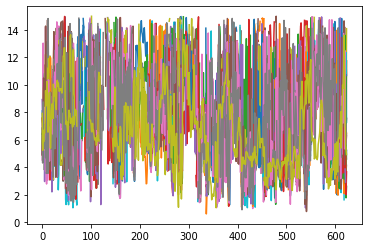

In [203]:
for k in ["Sck", "XGB"]:
    for i in range(-3, 6):
        plt.plot(mecin[f"{k}_zh_{i}"])
plt.plot(mecin["AR_zh_-3"]);

In [204]:
import plotly.graph_objs as go
from plotly.offline import plot

In [205]:
datas = []
for k in range(-3, 6):
    data = go.Scatter(x=frs.XGB_zh_0.index, y=frs[f"Sck_zh_{k}"], text=list(zip(frs.Zona_zh_5, frs.hora_zh_5)), name=f"Sck_{k}", hoverinfo='text', hovertemplate='%{text} hora %{y}_mape')
    datas.append(data)

fig=go.Figure(data = datas)
plot(fig)

'temp-plot.html'

In [206]:
datas = []
for k in range(-3, 6):
    data = go.Scatter(x=frs.XGB_zh_0.index, y=frs[f"XGB_zh_{k}"], text=list(zip(frs.Zona_zh_5, frs.hora_zh_5)), name=f"XGB_{k}", hoverinfo='text', hovertemplate='%{text} hora %{y}_mape')
    datas.append(data)

fig=go.Figure(data = datas)
plot(fig)

'temp-plot.html'

In [209]:
datas = []
for k in range(-3, 6):
    data = go.Scatter(x=frs.XGB_zh_0.index, y=frs[f"AR_zh_{k}"], text=list(zip(frs.Zona_zh_5, frs.hora_zh_5)), name=f"AR_{k}", hoverinfo='text', hovertemplate='%{text} hora %{y}_mape')
    data1 = go.Scatter(x=frs.XGB_zh_0.index, y=frs[f"XGB_zh_{k}"], text=list(zip(frs.Zona_zh_5, frs.hora_zh_5)), name=f"XGB_{k}", hoverinfo='text', hovertemplate='%{text} hora %{y}_mape')
    data2 = go.Scatter(x=frs.XGB_zh_0.index, y=frs[f"Sck_zh_{k}"], text=list(zip(frs.Zona_zh_5, frs.hora_zh_5)), name=f"AR_{k}", hoverinfo='text', hovertemplate='%{text} hora %{y}_mape')
    datas.append(data)
    datas.append(data1)
    datas.append(data2)

fig=go.Figure(data = datas)
plot(fig)

'temp-plot.html'

In [208]:
datas = []
for k in range(-3, 6):
    data1 = go.Scatter(x=mecin.XGB_zh_0.index, y=mecin[f"XGB_zh_{k}"], text=list(zip(mecin.Zona_zh_5, mecin.hora_zh_5)), name=f"XGB_{k}", hoverinfo='text', hovertemplate='%{text} hora %{y}_mape')
    data2 = go.Scatter(x=mecin.XGB_zh_0.index, y=mecin[f"Sck_zh_{k}"], text=list(zip(mecin.Zona_zh_5, mecin.hora_zh_5)), name=f"AR_{k}", hoverinfo='text', hovertemplate='%{text} hora %{y}_mape')
    datas.append(data1)
    datas.append(data2)

data = go.Scatter(x=mecin.XGB_zh_0.index, y=mecin[f"AR_zh_-3"], text=list(zip(mecin.Zona_zh_5, mecin.hora_zh_5)), name="AR", hoverinfo='text', hovertemplate='%{text} hora %{y}_mape')
datas.append(data)
fig=go.Figure(data = datas)
plot(fig)

'temp-plot.html'

In [525]:
# plt.figure(figsize = (20, 10))
# # plt.plot(fr.XGB)
# plt.plot(fr.Sck)
# plt.plot(fr.AR)
# plt.grid();

# plt.figure(figsize = (20, 10))
# # plt.plot(frzh.XGB)
# plt.plot(frzh.Sck)
# plt.plot(frzh.AR)
# plt.grid();

In [ ]:
import plotly.graph_objs as go
from plotly.offline import plot

In [162]:
data1=go.Scatter(x=fr.XGB.index, y=fr.Sck, text=list(zip(fr.Zona, fr.hora)), name="Sck", hoverinfo='text', hovertemplate='%{text} hora')
data2=go.Scatter(x=fr.XGB.index, y=fr.AR, text=list(zip(fr.Zona, fr.hora)), name='AR', hoverinfo='text', hovertemplate='%{text} hora')
fig=go.Figure(data = [data1, data2])
plot(fig)

'temp-plot.html'

In [181]:
data1=go.Scatter(x=frzh.Sck.index, y=frzh.Sck, text=list(zip(frzh.Zona, frzh.hora)), name='Sck', hoverinfo='text', hovertemplate='%{text} hora')
data2=go.Scatter(x=frzh.Sck.index, y=frzh.AR, text=list(zip(frzh.Zona, frzh.hora)), name='AR', hoverinfo='text', hovertemplate='%{text} hora')
fig=go.Figure(data = [data1,data2])
plot(fig)

'temp-plot.html'